In [1]:
import csv
import cv2
import numpy as np
from random import *

In [2]:
#Read the lines from excel sheet which contains the record of steering angles along with the corresponding images
lines=[]
with open('./data/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [3]:
#images list contains list of randomly selected images for each steering angle. For the left image an offset of 0.25 is added to 
#steering angle , for right image an offset of 0.25 is subtracted from the steering angle while for the center image the steering 
# angle is left as it is . This is done to keep the vehicle align with the center of road.
images=[]
measurements=[]
for line in lines[1:]:
    index = randint(0,2)
    current_path = './data/'+line[index].strip()
    image =  cv2.imread(current_path)
    #image = cv2.cvtColor(cv2.imread(current_path), cv2.COLOR_BGR2RGB)
    
    images.append(image)
    
    if (index==0):
        measurement=float(line[3])
    if (index==1):
        measurement=float(line[3])+0.25
    if (index==2):
        measurement=float(line[3])-0.25
    measurements.append(measurement)
    
    
    

In [4]:
#Randomly fliping the images and steering angle corrsponding to those images 
augment_images=[]
augment_measurement=[]
for image,measurement in zip(images,measurements):
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        augment_images.append(cv2.flip(image,1))
        augment_measurement.append(measurement*-1)
    augment_images.append(image)
    augment_measurement.append(measurement)
    

In [5]:
X_train = np.array(augment_images)
y_train = np.array(augment_measurement)

In [6]:
print(X_train.shape)
print(y_train.shape)

(12006, 160, 320, 3)
(12006,)


In [7]:
#Convolution Model to train the Network

from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Conv2D,Dropout,Cropping2D,Convolution2D


model = Sequential()
#To Normalize the data
model.add(Lambda(lambda x:x/255.0 - 0.5,input_shape=(160,320,3)))
#Reduce the size of the image to train the images faster
model.add(Cropping2D(cropping=((50,20), (0,0))))

#Layer 1: Conv layer with 24 5x5 filters
model.add(Convolution2D(24,5,5,activation='relu',subsample=(2,2)))
#Layer 2: Conv layer with 36 5x5 filters
model.add(Convolution2D(36,5,5,activation='relu',subsample=(2,2)))
#Layer 3: Conv layer with 48 5x5 filters
model.add(Convolution2D(48,5,5,activation='relu',subsample=(2,2)))
#Layer 4: Conv layer with 64 3x3
model.add(Convolution2D(64,3,3,activation='relu',subsample=(1,1)))
#Layer 5: Conv layer with 64 3x3
model.add(Convolution2D(64,3,3,activation='relu',subsample=(1,1)))
# Flatten the output
model.add(Flatten())
#layer 6
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.4))
#layer 7
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
#layer 8
model.add(Dense(10,activation='linear'))
model.add(Dropout(0.2))

# Finally a single output, since this is a regression problem
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')


Using TensorFlow backend.


In [8]:
#Execute and Save the model
history_object=model.fit(X_train,y_train,validation_split=0.3,shuffle=True,nb_epoch=5)
model.save('model.h5')

Train on 8404 samples, validate on 3602 samples
Epoch 1/5
8404/8404 [==============================] - 28s - loss: 0.0347 - val_loss: 0.0269
Epoch 2/5
8404/8404 [==============================] - 26s - loss: 0.0276 - val_loss: 0.0244
Epoch 3/5
8404/8404 [==============================] - 26s - loss: 0.0247 - val_loss: 0.0240
Epoch 4/5
8404/8404 [==============================] - 26s - loss: 0.0235 - val_loss: 0.0235
Epoch 5/5
8404/8404 [==============================] - 26s - loss: 0.0222 - val_loss: 0.0240


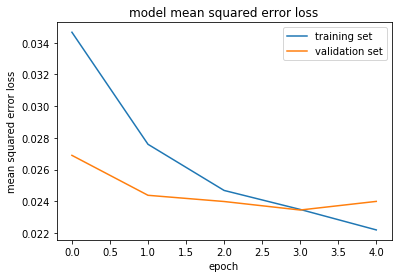

In [9]:
#Graph for the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()